# Physics Analysis: Dimuon spectrum

This tutorial shows you how to analyze datasets using `RDataFrame` from a Python notebook. The example analysis performs the following steps:

1. Connect a ROOT dataframe to a dataset containing 61 mio. events recorded by CMS in 2012
2. Filter the events being relevant for your analysis
3. Compute the invariant mass of the selected dimuon candidates
4. Plot the invariant mass spectrum showing resonances up to the Z mass

The notebook runs out-of-the-box. However, you are encouraged to tweak the code to see the effect on the result!

## Prelude: Using ROOT from Python

Python makes our lives easier but - in case you are not very careful - often also slower. To prevent this, you can learn in the following example how to combine the best of both worlds using `RDataFrame` and ROOT's [C++ interpreter](https://root.cern/cling/).

While ROOT is implemented in C++, it provides automatic Python bindings, called [PyROOT](https://root.cern/manual/python/). This means that all the ROOT C++ functionality is also available from Python, including `RDataFrame`.

You can compare this notebook to the C++ equivalent also presented in this training.

In [1]:
# This import gives access to all the ROOT C++ code from Python
import ROOT

Welcome to JupyROOT 6.20/06


## Create a ROOT dataframe in Python

The ROOT interface in Python is directly mapped from the C++ API. Since we talk to a C++ library in the back, PyROOT supports to create any C++ type in the Python world out-of-the-box so you can pass data to your C++ library. Python is just the interface language here: all the heavy lifting happens in C++, which is good for performance!

Let's see that in action. First we will create a ROOT dataframe that is connected to a dataset named `Events` stored in a ROOT file. The file is pulled in via [XRootD](http://xrootd.org/) from EOS public, but note how it could also be stored in your CERNBox space or in any other EOS repository accessible from SWAN (e.g. the experiment ones).

The dataset `Events` is a `TTree` (a "table" in first order) and has the following branches (also referred to as "columns"):

| Branch name | Data type | Description |
|-------------|-----------|-------------|
| `nMuon` | `unsigned int` | Number of muons in this event |
| `Muon_pt` | `float[nMuon]` | Transverse momentum of the muons stored as an array of size `nMuon` |
| `Muon_eta` | `float[nMuon]` | Pseudo-rapidity of the muons stored as an array of size `nMuon` |
| `Muon_phi` | `float[nMuon]` | Azimuth of the muons stored as an array of size `nMuon` |
| `Muon_charge` | `int[nMuon]` | Charge of the muons stored as an array of size `nMuon` and either -1 or 1 |
| `Muon_mass` | `float[nMuon]` | Mass of the muons stored as an array of size `nMuon` |

In [2]:
df = ROOT.RDataFrame("Events", "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root");

## Inspect the dataset

There a few operations that we can use to inspect the dataset we just created. First, we can see the column names:

In [3]:
print(df.GetColumnNames())

{ "nMuon", "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_charge" }


Now we can check the type of one of those columns:

In [4]:
df.GetColumnType("nMuon")

'UInt_t'

We can also see how the dataset looks like (this will read the first five rows):

In [5]:
display = df.Display()
display.Print()

nMuon | Muon_pt  | Muon_eta   | Muon_phi    | Muon_mass | Muon_charge | 
2     | 10.7637f | 1.06683f   | -0.0342727f | 0.105658f | -1          | 
      | 15.7365f | -0.563787f | 2.54262f    | 0.105658f | -1          | 
2     | 10.5385f | -0.427780f | -0.274792f  | 0.105658f | 1           | 
      | 16.3271f | 0.349225f  | 2.53978f    | 0.105658f | -1          | 
1     | 3.27533f | 2.21086f   | -1.22341f   | 0.105658f | 1           | 
4     | 11.4292f | -1.58824f  | -2.07730f   | 0.105658f | 1           | 
      | ...      | ...        | ...         | ...       | ...         | 
      | 3.50223f | -1.65596f  | -1.84997f   | 0.105658f | 1           | 
4     | 3.28344f | -2.17248f  | -2.37001f   | 0.105658f | -1          | 
      | ...      | ...        | ...         | ...       | ...         | 
      | 23.7218f | -1.16290f  | -0.773005f  | 0.105658f | 1           | 


## Filter relevant events for this analysis

Physics datasets are often general purpose datasets and therefore need extensive filtering of the events for the actual analysis. Here, we implement only a simple selection based on the number of muons and the charge to cut down the dataset in events that are relevant for our study.

In particular, we are applying two filters to keep:
1. Events with exactly two muons
2. Events with muons of opposite charge

In [6]:
df_2mu = df.Filter("nMuon == 2", "Events with exactly two muons")
df_os = df_2mu.Filter("Muon_charge[0] != Muon_charge[1]", "Muons with opposite charge")

## Compute the invariant mass of the dimuon system

Since we want to see the resonances in the mass spectrum, where dimuon events are more likely, we need to compute the invariant mass from the four-vectors of the muon candidates. Because this operation is non-trivial, we will use ROOT's `ROOT::VecOps::InvariantMass` function to do the job for us.

The invariant mass will be stored in a new column that we will create with the `Define` operation of `RDataFrame`. The parameters of `Define` are the name of the new column and a string with the function to be invoked, which includes the dataset columns to be used as arguments for the such function.

Note how, even though `ROOT::VecOps::InvariantMass` is a C++ function, we can use it in our `RDataFrame` workflow from Python: the second parameter of `Define` is a string that contains C++ code. Such code will be just-in-time compiled by ROOT and called during the event loop in C++. This allows to benefit from C++ performance in computationally-expensive code even when programming in Python.

In [7]:
df_mass = df_os.Define("Dimuon_mass", "ROOT::VecOps::InvariantMass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)")

## Run only on a part of the dataset

The full dataset contains half a year of CMS data taking in 2012 with 61 mio events. For the purpose of this example, we use the `Range` node to run only on a small part of the dataset. This feature also comes in handy in the development phase of your analysis.

Feel free to experiment with this parameter!

In [8]:
num_events = df.Count()
print(f"Number of events of this dataset: {num_events.GetValue()}")

Number of events of this dataset: 61540413


In [9]:
# Take only the first 1M events
df_range = df_mass.Range(1000000);

## What are the cuts doing?

To find out how many events the cuts are throwing away, we can book another endpoint of the graph to look at the efficiency of the placed cuts.

In [10]:
report = df_range.Report()
report.Print()

Events with exactly two muons: pass=1315892    all=2676243    -- eff=49.17 % cumulative eff=49.17 %
Muons with opposite charge: pass=1000000    all=1315892    -- eff=75.99 % cumulative eff=37.37 %


## Make a histogram of the dimuon spectrum

As (almost) always in physics, we have a look at the results in the form of a histogram. Let's book a histogram as one endpoint of our computation graph.

In [11]:
nbins = 30000
low = 0.25
up = 300
h = df_range.Histo1D(("Dimuon_mass", "Dimuon_mass", nbins, low, up), "Dimuon_mass")

## Plot the dimuon spectrum

Now, the computation graph is set up. Next, we want to have a look at the result.

Note that the event loop actually runs the first time we try to access the histogram object (results of an `RDataFrame` graph are computed lazily).

`%%time` measures the time spend in the full cell. You can compare it with the C++ equivalent of this notebook, it should be very similar since (almost) everything happens in C++ under the hood!

In [12]:
%%time

ROOT.gStyle.SetOptStat(0); ROOT.gStyle.SetTextFont(42)
c = ROOT.TCanvas("c", "", 800, 700)
c.SetLogx(); c.SetLogy()
h.SetTitle("")
h.GetXaxis().SetTitle("m_{#mu#mu} (GeV)"); h.GetXaxis().SetTitleSize(0.04)
h.GetYaxis().SetTitle("N_{Events}"); h.GetYaxis().SetTitleSize(0.04)
h.Draw()

label = ROOT.TLatex(); label.SetNDC(True)
label.SetTextSize(0.040); label.DrawLatex(0.100, 0.920, "#bf{CMS Open Data}")
label.SetTextSize(0.030); label.DrawLatex(0.500, 0.920, "#sqrt{s} = 8 TeV, L_{int} = 11.6 fb^{-1}");

CPU times: user 5.43 s, sys: 366 ms, total: 5.8 s
Wall time: 6.54 s


ROOT provides interactive JavaScript graphics for Jupyter, which can be activated with the `%jsroot` magic. Click and drag on the axis to zoom in and double click to reset the view.

Don't forget that you can improve the statistics by increasing the number of events given to `Range`.

In [13]:
%jsroot on
c.Draw()

## Use other tools

SWAN also provides other tools of the Python data science ecosystem, so that users are not restricted to any particular library. For a full list of the software packages available in SWAN, please check the [LCG releases website](http://lcginfo.cern.ch/).

Therefore, let's see how to use some of these Python libraries for data analysis from SWAN. Since `RDataFrame` allows to export ROOT data to [NumPy](https://numpy.org/) format, this opens the door to use those other tools. A typical workflow would be to do the heavy computation in C++ with `RDataFrame` and push only the required data to Python for further manipulation / plotting. The relevant method here is `AsNumpy`:

In [14]:
# dimuon_mass is a dictionary that contains the "Dimuon_mass" column of the dataset in the form of a NumPy array
dimuon_mass = df_range.AsNumpy(['Dimuon_mass'])
dimuon_mass

/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/ROOT.py:421: FutureWarning: Instantiating a function template with parentheses ( f(type1, ..., typeN) ) is deprecated and will not be supported in a future version of ROOT. Instead, use square brackets: f[type1, ..., typeN]
  result_ptrs[column] = _root.ROOT.Internal.RDF.RDataFrameTake(column_type)(df_rnode, column)


{'Dimuon_mass': ndarray([ 27.915493 , 113.646866 ,   1.5878606, ...,   0.5761818,
            1.7127737,  84.608795 ], dtype=float32)}

The result of AsNumpy can be directly used to construct a [pandas](https://pandas.pydata.org/) dataframe:

In [15]:
import pandas
pdf = pandas.DataFrame(dimuon_mass)
pdf

,Dimuon_mass
0,27.915493
1,113.646866
2,1.587861
3,23.723238
4,0.738188
5,27.116903
6,1.571148
7,1.638615
8,1.169581
9,30.712582


Or we can make a plot with [matplotlib](https://matplotlib.org/):

<IPython.core.display.Javascript object>


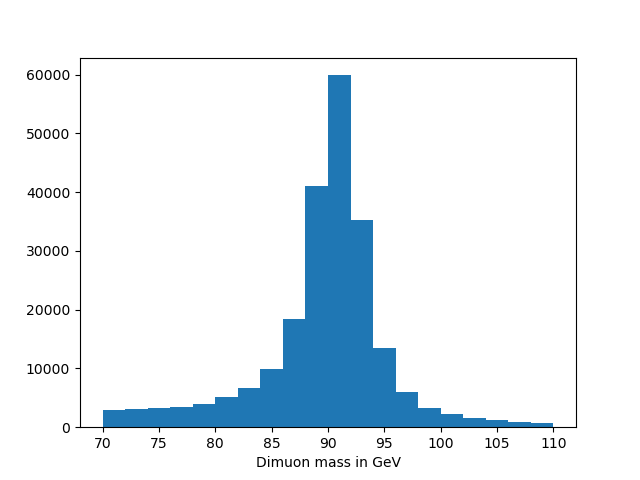

In [16]:
%matplotlib notebook

import matplotlib.pyplot as plt
plt.hist(dimuon_mass['Dimuon_mass'], range=(70, 110), bins=20)
plt.xlabel('Dimuon mass in GeV')
plt.show()